# Analysis

In [2]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['axes.spines.left'] = True
plt.rcParams['axes.spines.bottom'] = True
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.facecolor'] = 'white'

## Number of sequences in each strain

Calculate and plot the number of sequences required to extract the DNA for each strain.

In [3]:
def plot_info_sequences(dataframe):
    
    plt.figure(figsize=(45,12))
    plt.title('Number of sequences for each strain')
    
    palette = sns.color_palette('colorblind', n_colors=len(dataframe['Database'].unique()))
    category_color_map = {category: color for category, color in zip(dataframe['Database'].unique(), palette)}
    
    legend_entries = {}
    
    for index, row in dataframe.iterrows():
        category = row['Database']
        
        if category not in legend_entries:
            legend_entries[category] = plt.bar(row['Strain'], row['Number of sequences'], color=category_color_map[category], label=category)
        else:
            plt.bar(row['Strain'], row['Number of sequences'], color=category_color_map[category])
    
    plt.xlabel('Strain')
    plt.ylabel('Number of sequences')
    plt.xticks(rotation=45, ha='right')
    
    plt.legend()
    plt.tight_layout()
    
    # os.makedirs(f"./Result/Images/", exist_ok=True)
    # output_path = os.path.join(f"./Result/Images/{file_name}.png")
    # plt.savefig(output_path)
    
    plt.show()
    plt.close()

,Number of sequences,Database
Strain,,
GCA_007992315,41,ncbi
GCA_002259745,28,ncbi
GCA_000771085,0,ncbi
GCA_000010425,1,ncbi
GCA_002706745,1,ncbi
...,...,...
862514.3,1,Patric
1220560.3,101,Patric
203120.23,1,Patric


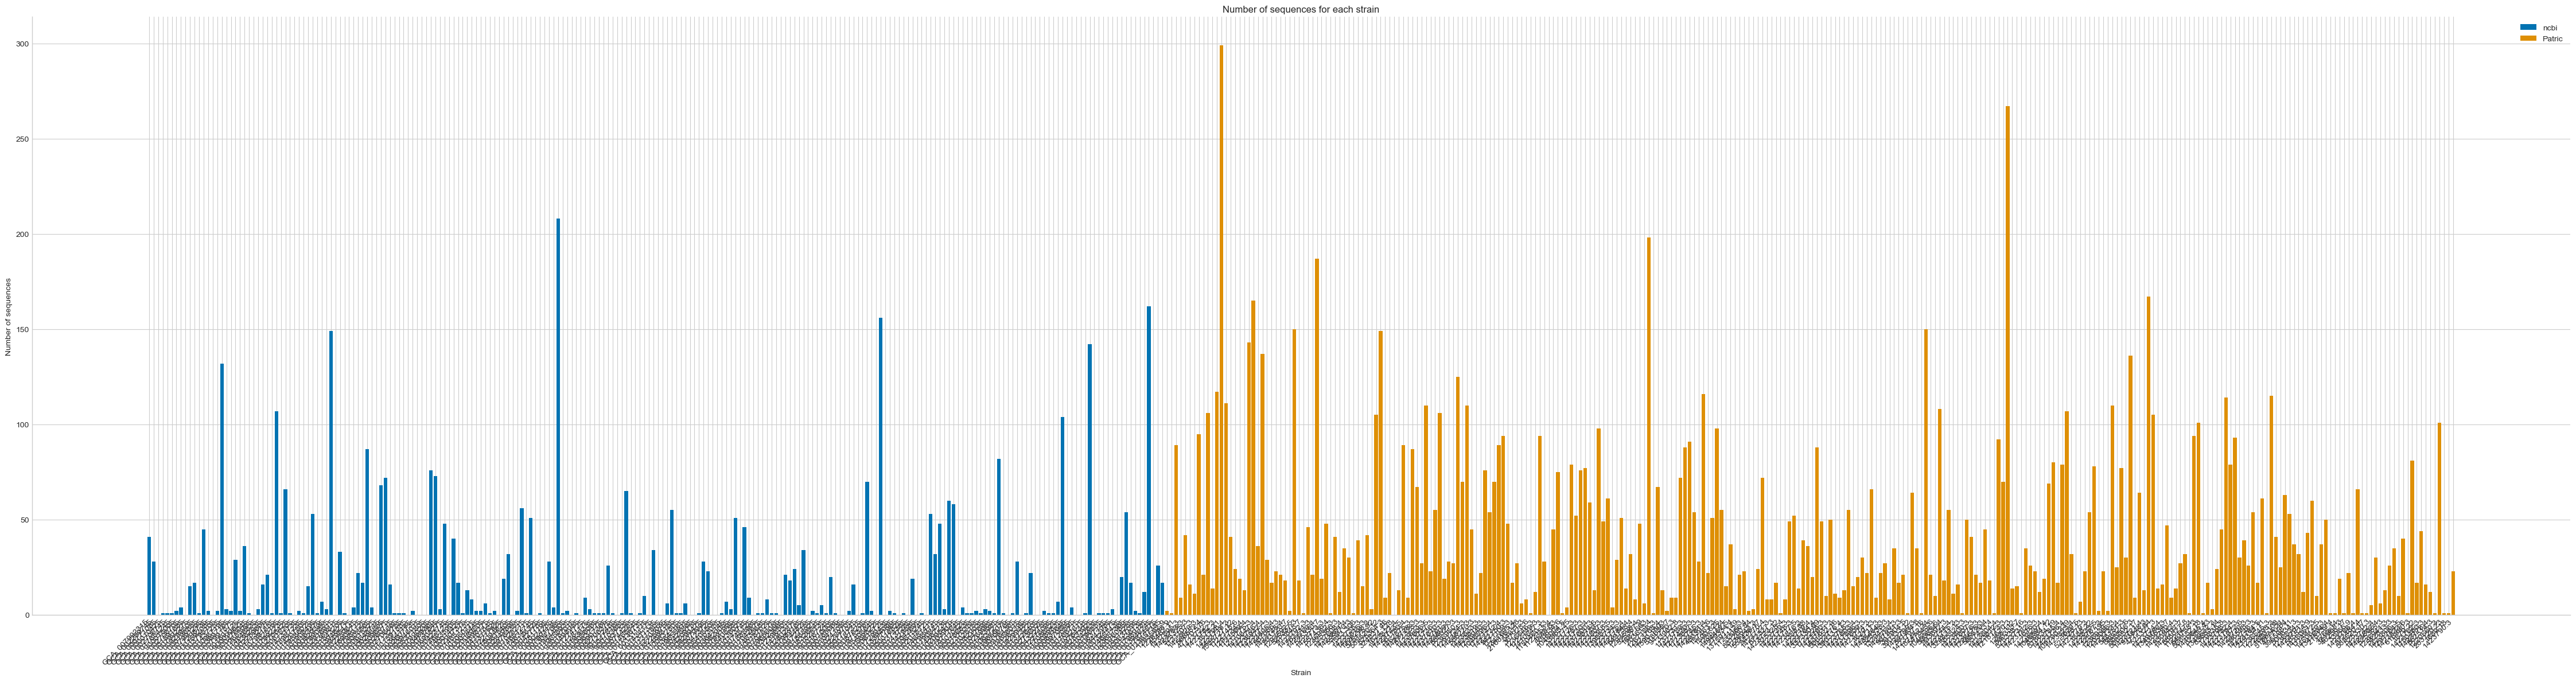

In [6]:
path = 'Result/Coverages/Gene_Importances/AMYgdalin/' # There is no differences between folders for this analysis.
output = pd.DataFrame(columns=['Strain', 'Number of sequences', 'Database'])

files = os.listdir(path)
xlsx_files = [file for file in files if file.endswith('.xlsx')]


for file in xlsx_files:
    if not file.startswith('~$'): # Avoid reading xlsx files that are temporarily open.
        file_path = os.path.join(path, file)

        coverage = pd.read_excel(file_path)

        strain = file[:-5]
        num_sequences = len(coverage['Sequence'].unique())
        database = 'ncbi' if file.startswith('GCA') else 'Patric'

        row = pd.DataFrame({'Strain': [strain], 'Number of sequences': [num_sequences], 'Database': [database]})
        
        output = pd.concat([output, row], ignore_index=True)            
        
output = output.sort_values(by=['Database'], ascending=False)

display(output.set_index('Strain'))
plot_info_sequences(output)

with pd.ExcelWriter('./Result/strain_sequences.xlsx') as writer:
    output.to_excel(writer, index=False)

## Coverage of DNA

Calculate and plot the coverage of the DNA captured by AFLP.

In [5]:
def caluclate_aflp_coverage(strain, aflp_min, aflp_max):
    coverages = dict()
    
    print(filemap[strain], end=', ')
    
    with open('Data/BacDive/AFLP_perl/'+filemap[strain], 'r') as iff:
        for line in iff:
            
            cc = line.strip().split('\t')
            
            if len(cc) == 9: # prende in considerazioni righe fatte da 9 campi, come: 1	KE386622	1745633	GAATTC	534628	TTAA	534632	10	TTAAGAATTC

                flen = int(cc[7]) # fragment_length
                
                if (flen>=aflp_min) and (flen<=aflp_max):
                    seq = cc[1]

                    if seq not in coverages:
                        coverages[seq] = [False for i in range(int(cc[2]))]

                    istart = int(cc[4])
                    imax = int(cc[6])
                    if istart > imax:
                        print(cc)
                    for i in range(istart, istart+flen):
                        coverages[seq][i] = True
    covered = 0
    total = 0
    for k,v in coverages.items():
        total += len(v)
        covered += sum(v)
        # print('#',k, len(v), sum(v))
    return covered, total

In [ ]:
filemap = dict()
aflp_coverages = list()

files = [f for f in os.listdir('Data/BacDive/AFLP_perl') if os.path.isfile('Data/BacDive/AFLP_perl/'+f)]
df_X = pd.read_excel('Data/X.xlsx')
strains = list(df_X['strain'])


for f in files:
    if 'GCA' in f:
        filemap[f[:f.index('.')]] = f
    else:
        filemap[f.replace('.wri','')] = f
        

for st in strains:
    covered, total = caluclate_aflp_coverage(st, 50, 500)
    
    if total > 0 :
        aflp_coverages.append(covered/total)
    else:
        aflp_coverages.append(0)
        
        

# Plot the coverage        
plt.figure(figsize=(7, 7))

plt.scatter( [i for i in range(len(aflp_coverages))], sorted(aflp_coverages), marker='D', s=15)

plt.title('AFLP coverage', fontsize=15, pad=20)
plt.xlabel('Sample', fontsize=13)
plt.ylabel('Coverage', fontsize=13)

plt.xticks(fontsize=11)
plt.yticks(fontsize=11)

plt.savefig('Result/Images/coverage.png')
plt.show()